---
title: NerFs for SSH
date: 2023-08-09
subject: Neural Fields for SSH Interpolation
subtitle: Naive Nerfs applied to SSH Data
short_title: OSSE NADIR + SWOT
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    NerF: Neural Field
---

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import pandas as pd
import keras_core as keras
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using JAX backend.


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a very simple spatial interpolation problem for sea surface height.

## Data

In [2]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/

gf_mod_ssh_daily.nc       gf_obs_nadir.nc.dvc       natl_mod_ssh_daily.nc.dvc
gf_mod_ssh_daily.nc.dvc   gf_obs_nadirswot.nc       natl_mod_sst.nc.dvc
gf_mod_sst.nc             gf_obs_nadirswot.nc.dvc   natl_obs_nadir.nc.dvc
gf_mod_sst.nc.dvc         gf_obs_swot.nc            natl_obs_nadirswot.nc.dvc
gf_obs_nadir.nc           gf_obs_swot.nc.dvc


In [3]:
import xarray as xr
from oceanbench._src.geoprocessing.temporal import time_rescale


xrds = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_obs_nadirswot.nc")
xrds = xrds.sel(time=slice("2012-10-01","2012-12-02"))
xrds_true = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_mod_ssh_daily.nc")
xrds_true = xrds_true.sel(time=slice("2012-10-01","2012-12-02"))
xrds["ssh"] = (("time", "lat", "lon"), xrds_true["ssh"].transpose("time", "lat", "lon").data)
#
xrds = time_rescale(xrds, freq_dt=1, freq_unit="seconds", t0=None)
xrds

<xarray.Dataset>
Dimensions:      (lat: 201, lon: 201, time: 63)
Coordinates:
  * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * time         (time) float32 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
Data variables:
    mask         (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    lag          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    flag         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ssh_obs      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ssh_mod      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    anomaly_obs  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    anomaly_mod  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ssh          (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [4]:
xrds_true, xrds

(<xarray.Dataset>
 Dimensions:  (time: 63, lat: 201, lon: 201)
 Coordinates:
   * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
   * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
   * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2012-12-02T12:00:00
 Data variables:
     ssh      (time, lat, lon) float64 ...,
 <xarray.Dataset>
 Dimensions:      (lat: 201, lon: 201, time: 63)
 Coordinates:
   * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
   * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
   * time         (time) float32 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
 Data variables:
     mask         (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
     lag          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
     flag         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
     ssh_obs      (time, lat, lon) float64 nan 

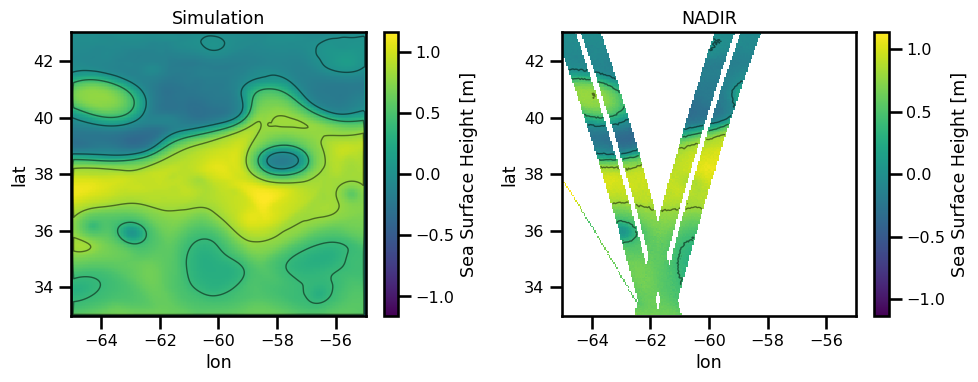

In [5]:
from matplotlib import ticker

variable = "ssh"

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

subset_ds = xrds.isel(time=5)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds["ssh"].plot.pcolormesh(ax=ax[0], cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds["ssh"].min().values, xrds["ssh"].max().values)
subset_ds["ssh"].plot.contour(
    ax=ax[0], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[0].set(title="Simulation")

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds["ssh_obs"].plot.pcolormesh(ax=ax[1], cmap="viridis", cbar_kwargs=cbar_kwargs)


subset_ds["ssh_obs"].plot.contour(
    ax=ax[1], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[1].set(title="NADIR")

plt.tight_layout()
plt.show()

In [6]:
dfds = xrds[["ssh", "ssh_obs"]].to_dataframe().reset_index()
# apply coordinate transformation
dfds.describe()

,time,lat,lon,ssh,ssh_obs
count,2.545263e+06,2.545263e+06,2.545263e+06,2.545263e+06,263543.000000
mean,2.678400e+06,3.800000e+01,-6.000000e+01,4.224794e-01,0.414999
std,1.571119e+06,2.901150e+00,2.901150e+00,3.929870e-01,0.410593
min,0.000000e+00,3.300000e+01,-6.500000e+01,-4.421602e-01,-0.466800
25%,1.296000e+06,3.550000e+01,-6.250000e+01,0.000000e+00,-0.025600
50%,2.678400e+06,3.800000e+01,-6.000000e+01,4.946982e-01,0.495100
75%,4.060800e+06,4.050000e+01,-5.750000e+01,7.569129e-01,0.780400
max,5.356800e+06,4.300000e+01,-5.500000e+01,1.198458e+00,1.220100


In [7]:
from nerf4ssh._src.transforms.scaling import MinMaxDF

scaler = MinMaxDF(columns=["lon", "lat", "time"])
scaler.fit(dfds)

train_dfds = dfds.dropna()

x = scaler.fit_transform(train_dfds).values
y = train_dfds[["ssh_obs"]].values

x_eval = scaler.transform(dfds).values



x.shape, y.shape

((263543, 3), (263543, 1))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [8]:
# xrda["ssh_pre"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)

In [9]:
from nerf4ssh._src.losses import psnr

In [10]:
input_shape = (3,)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(1, activation=None),
    ]
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)               │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,689 (2.04 MB)

 Trainable params: 66,689 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_mlp_osse_nadir_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [13]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [17]:
batch_size = 2048
epochs = 100
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [18]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [19]:
history_mlp = model.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0680 - psnr: 18.9126 - val_loss: 0.0250 - val_psnr: 24.6437
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0539 - psnr: 20.5389 - val_loss: 0.0244 - val_psnr: 24.6250
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0536 - psnr: 20.5474 - val_loss: 0.0239 - val_psnr: 24.4715
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0533 - psnr: 20.6361 - val_loss: 0.0236 - val_psnr: 24.4121
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0532 - psnr: 20.6471 - val_loss: 0.0234 - val_psnr: 24.4059
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0531 - psnr: 20.6662 - val_loss: 0.0234 - val_psnr: 24.3630
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0530 - psnr: 20.7588 - val_loss: 0.0234 - val_psnr: 24.6481
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0521 - psnr: 20.8317 - val_loss: 0.0235 - val_psnr: 24.5538
Epoch 9/

In [82]:
model.save("saved_models/final_model_mlp.keras")

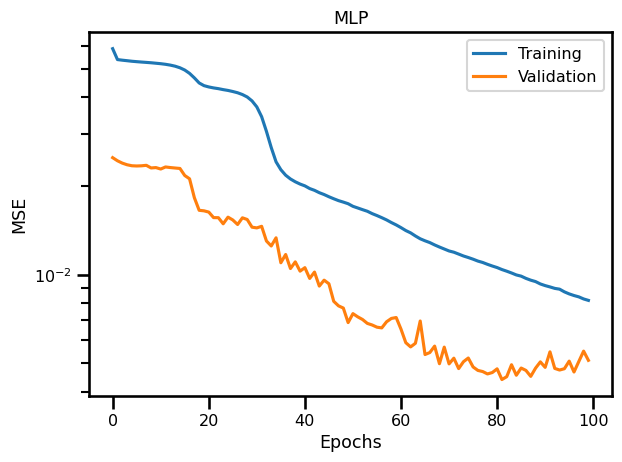

In [21]:
fig, ax = plt.subplots()

ax.plot(history_mlp.epoch, history_mlp.history['loss'], label="Training")
ax.plot(history_mlp.epoch, history_mlp.history['val_loss'], label="Validation")
ax.set(
    title="MLP",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
score = model.evaluate(x=x, y=y, verbose=1)

8236/8236 ━━━━━━━━━━━━━━━━━━━━ 6s 720us/step - loss: 0.0078 - psnr: 28.8571


In [23]:
x_eval = scaler.transform(dfds).values

predictions = model.predict(x=x_eval)

79540/79540 ━━━━━━━━━━━━━━━━━━━━ 15s 187us/step


In [24]:
dfds["ssh_mlp"] = predictions

In [25]:
dfds.head()


,time,lat,lon,ssh,ssh_obs,ssh_mlp
0,0.0,33.0,-65.00,0.0,NaN,0.450886
1,0.0,33.0,-64.95,0.0,NaN,0.449087
2,0.0,33.0,-64.90,0.0,NaN,0.447952
3,0.0,33.0,-64.85,0.0,NaN,0.447477
4,0.0,33.0,-64.80,0.0,NaN,0.447654


In [26]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_obs", "ssh_mlp"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 63, lat: 201, lon: 201)
Coordinates:
  * time     (time) float64 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_obs  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ssh_mlp  (time, lat, lon) float32 0.4509 0.4491 0.448 ... -0.2463 -0.2495

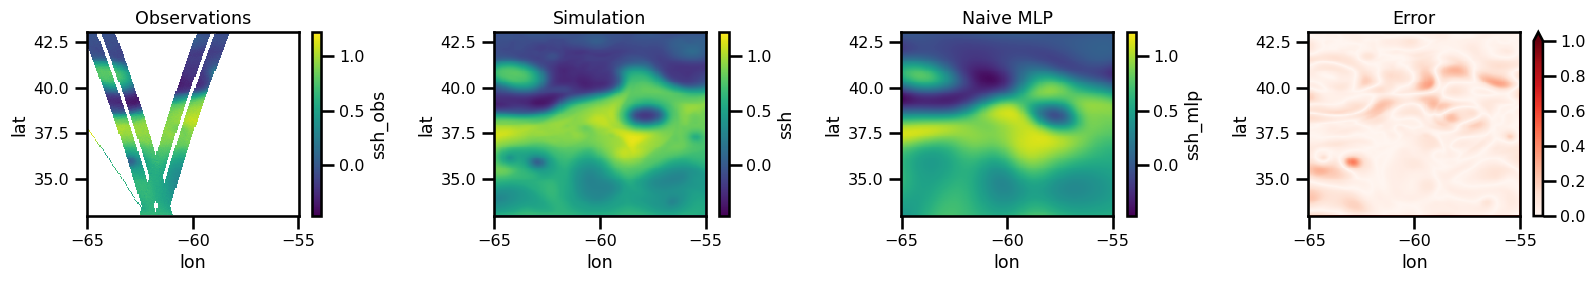

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

time = 5

vmin = xrds_.ssh_obs.min()
vmax = xrds_.ssh_obs.max()

xrds_.ssh_obs.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Observations")

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Simulation")

xrds_.ssh_mlp.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="Naive MLP")

np.abs(xrds_.ssh_mlp-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[3], cmap="Reds", vmin=0.0, vmax=1.0)
ax[3].set(title="Error")

plt.tight_layout()
plt.show()

### Random Fourier Features

In [40]:
from nerf4ssh._src.models.rff import RFFLayer

In [41]:
input_shape = (3,)
model_rff = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        RFFLayer(num_features=128),
        keras.layers.Dense(units=128, activation=None),
        RFFLayer(num_features=64),
        keras.layers.Dense(units=64, activation=None),
        RFFLayer(num_features=64),
        keras.layers.Dense(units=128, activation=None),
        RFFLayer(num_features=128),
        keras.layers.Dense(units=1),
    ]
)

In [42]:
model_rff.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rff_layer_20 (RFFLayer)         │ (None, 256)               │        386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rff_layer_21 (RFFLayer)         │ (None, 128)               │      8,194 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rff_layer_22 (RFFLayer)         │ (None, 128)               │      4,098 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rff_layer_23 (RFFLayer)         │ (None, 256)               │     16,386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 1)                 │        257 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 86,985 (2.65 MB)

 Trainable params: 57,929 (1.77 MB)

 Non-trainable params: 29,056 (908.00 KB)

In [43]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_rff_spatiotemporal_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [44]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_rff_osse_nadir.keras")

In [45]:
batch_size = 4096
epochs = 100
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [46]:
model_rff.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [47]:
x.shape

(263543, 3)

In [ ]:
train_lengths = [
    5_000, 10_000, 25_000, 50_000, 75_000, 
    100_000, 125_000, 150_000, 175_000, None
]

In [ ]:
from tqdm.notebook import tqdm
for itrain in tqdm(train_lengths):
    history_rff = model_rff.fit(
        x=x[:itrain], y=y[:itrain],
        validation_split=0.1,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )

In [48]:
history_rff = model_rff.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.3265 - psnr: 10.0317 - val_loss: 0.2294 - val_psnr: 9.4972
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2354 - psnr: 9.0702 - val_loss: 0.2088 - val_psnr: 9.2684
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2174 - psnr: 9.1315 - val_loss: 0.2013 - val_psnr: 9.2691
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2067 - psnr: 9.2645 - val_loss: 0.1951 - val_psnr: 9.3287
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1977 - psnr: 9.4447 - val_loss: 0.1901 - val_psnr: 9.4215
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1902 - psnr: 9.6762 - val_loss: 0.1864 - val_psnr: 9.4938
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1841 - psnr: 9.9627 - val_loss: 0.1838 - val_psnr: 9.5442
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1785 - psnr: 10.2589 - val_loss: 0.1821 - val_psnr: 9.6040
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━

In [81]:
model_rff.save("saved_models/final_model_rff_osse_nadirswot.keras")

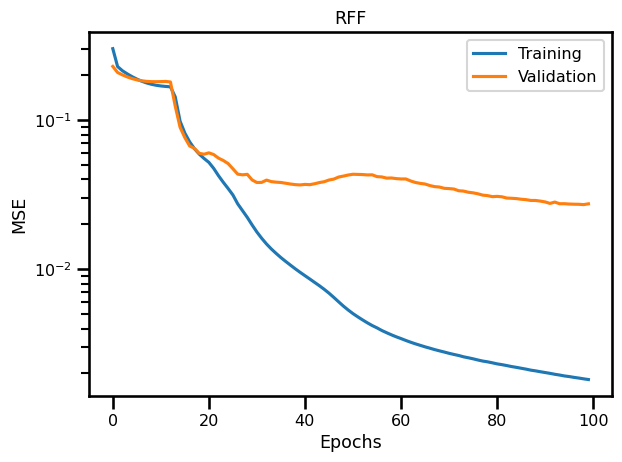

In [50]:
fig, ax = plt.subplots()

ax.plot(history_rff.epoch, history_rff.history['loss'], label="Training")
ax.plot(history_rff.epoch, history_rff.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
score = model_rff.evaluate(x=x, y=y, verbose=1)

8236/8236 ━━━━━━━━━━━━━━━━━━━━ 7s 836us/step - loss: 0.0020 - psnr: 34.7366


In [52]:

predictions = model_rff.predict(x=x_eval)

79540/79540 ━━━━━━━━━━━━━━━━━━━━ 20s 249us/step


In [53]:
dfds["ssh_rff"] = predictions

In [54]:
dfds.head()


,time,lat,lon,ssh,ssh_obs,ssh_mlp,ssh_rff
0,0.0,33.0,-65.00,0.0,NaN,0.450886,0.576195
1,0.0,33.0,-64.95,0.0,NaN,0.449087,0.577667
2,0.0,33.0,-64.90,0.0,NaN,0.447952,0.579337
3,0.0,33.0,-64.85,0.0,NaN,0.447477,0.581198
4,0.0,33.0,-64.80,0.0,NaN,0.447654,0.583243


In [55]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_obs", "ssh_mlp", "ssh_rff"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 63, lat: 201, lon: 201)
Coordinates:
  * time     (time) float64 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_obs  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ssh_mlp  (time, lat, lon) float32 0.4509 0.4491 0.448 ... -0.2463 -0.2495
    ssh_rff  (time, lat, lon) float32 0.5762 0.5777 0.5793 ... -0.1224 -0.1091

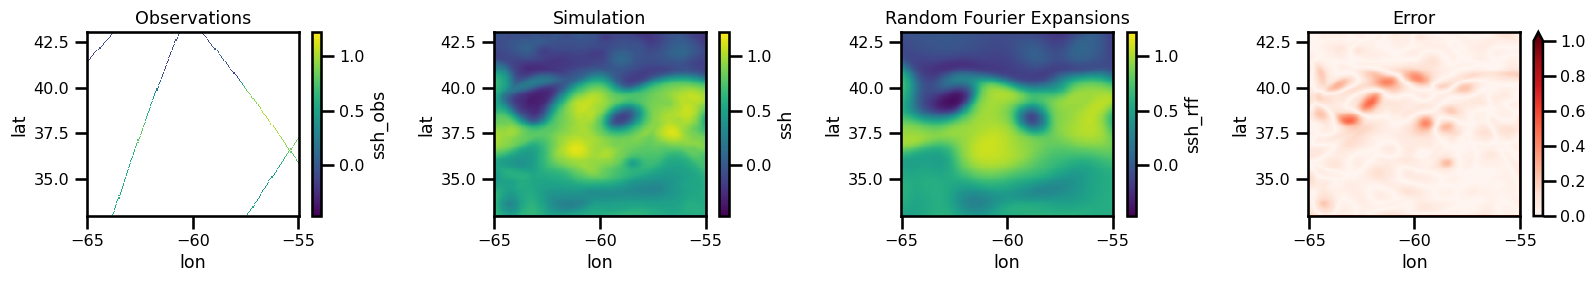

In [72]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

time = 41

vmin = xrds_.ssh_obs.min()
vmax = xrds_.ssh_obs.max()

xrds_.ssh_obs.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Observations")

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Simulation")

xrds_.ssh_rff.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="Random Fourier Expansions")

np.abs(xrds_.ssh_rff-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[3], cmap="Reds", vmin=0.0, vmax=1.0)
ax[3].set(title="Error")

plt.tight_layout()
plt.show()

### SIREN

In [73]:
from nerf4ssh._src.models.siren import SirenLayer

In [74]:
input_shape = (3,)
c = 6
omega_0 = 30
omega = 1.0
model_siren = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        SirenLayer(units=128, omega=omega_0, c=c, layer_type="first"),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=1, omega=omega, c=c, layer_type="last"),
    ]
)

In [75]:
model_siren.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ siren_layer (SirenLayer)        │ (None, 128)               │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_1 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_2 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_3 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_4 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_5 (SirenLayer)      │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,689 (2.04 MB)

 Trainable params: 66,689 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [77]:
batch_size = 32
epochs = 100
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [78]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_siren_spatiotemporal_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [79]:
model_siren.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [80]:
history_siren = model_siren.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 6s 744us/step - loss: 0.0442 - psnr: 23.9387 - val_loss: 0.0701 - val_psnr: 17.3921
Epoch 2/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 5s 707us/step - loss: 0.0018 - psnr: 33.6247 - val_loss: 0.0562 - val_psnr: 18.3433
Epoch 3/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 5s 702us/step - loss: 0.0011 - psnr: inf - val_loss: 0.0460 - val_psnr: 19.3845
Epoch 4/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 5s 698us/step - loss: 8.6432e-04 - psnr: 36.5699 - val_loss: 0.0433 - val_psnr: 19.6818
Epoch 5/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 5s 698us/step - loss: 7.3588e-04 - psnr: 37.1892 - val_loss: 0.0401 - val_psnr: 20.1426
Epoch 6/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 5s 702us/step - loss: 6.7900e-04 - psnr: 37.5918 - val_loss: 0.0379 - val_psnr: 20.2296
Epoch 7/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 5s 708us/step - loss: 6.1634e-04 - psnr: 38.0037 - val_loss: 0.0335 - val_psnr: 21.2958
Epoch 8/100
7413/7413 ━━━━━━━━━━━━━━━━━━━━ 6s 742us/step - loss: 5.8802e-04 - psnr: 38.2255 - val_l

In [ ]:
# model.save("saved_models/final_model_mlp.keras")

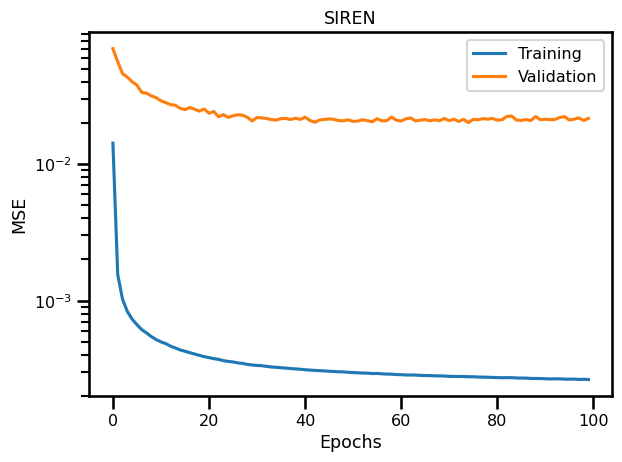

In [83]:
fig, ax = plt.subplots()

ax.plot(history_siren.epoch, history_siren.history['loss'], label="Training")
ax.plot(history_siren.epoch, history_siren.history['val_loss'], label="Validation")
ax.set(
    title="SIREN",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
score = model_siren.evaluate(x=x, y=y, verbose=1)

8236/8236 ━━━━━━━━━━━━━━━━━━━━ 5s 561us/step - loss: 3.4687e-04 - psnr: inf


In [85]:
predictions = model_siren.predict(x=x_eval)

79540/79540 ━━━━━━━━━━━━━━━━━━━━ 14s 180us/step


In [86]:
dfds["ssh_siren"] = predictions

In [87]:
dfds.head()


,time,lat,lon,ssh,ssh_obs,ssh_mlp,ssh_rff,ssh_siren
0,0.0,33.0,-65.00,0.0,NaN,0.450886,0.576195,0.269613
1,0.0,33.0,-64.95,0.0,NaN,0.449087,0.577667,0.242827
2,0.0,33.0,-64.90,0.0,NaN,0.447952,0.579337,0.222140
3,0.0,33.0,-64.85,0.0,NaN,0.447477,0.581198,0.209348
4,0.0,33.0,-64.80,0.0,NaN,0.447654,0.583243,0.205877


In [88]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_obs", "ssh_mlp", "ssh_rff", "ssh_siren"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:    (time: 63, lat: 201, lon: 201)
Coordinates:
  * time       (time) float64 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
  * lat        (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * lon        (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_obs    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ssh_mlp    (time, lat, lon) float32 0.4509 0.4491 0.448 ... -0.2463 -0.2495
    ssh_rff    (time, lat, lon) float32 0.5762 0.5777 0.5793 ... -0.1224 -0.1091
    ssh_siren  (time, lat, lon) float32 0.2696 0.2428 0.2221 ... 0.0108 0.003237

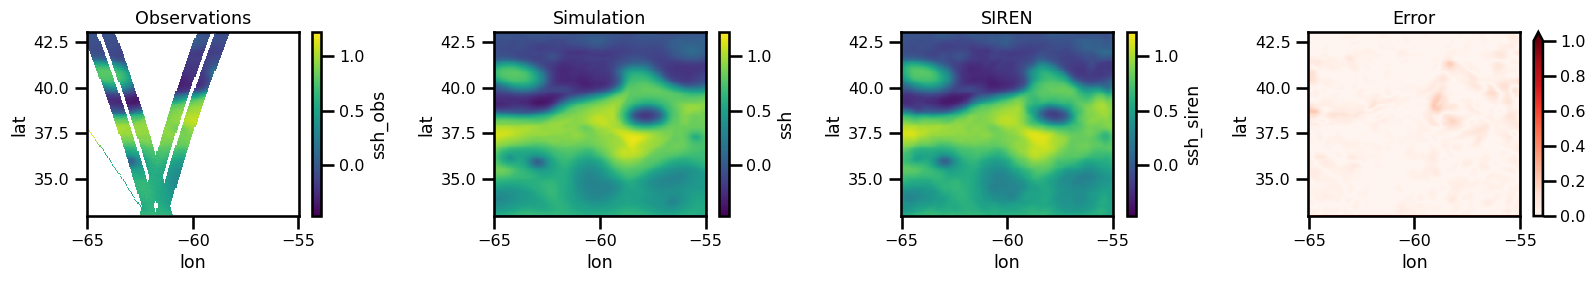

In [89]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

time = 5

vmin = xrds_.ssh_obs.min()
vmax = xrds_.ssh_obs.max()

xrds_.ssh_obs.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Observations")

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Simulation")

xrds_.ssh_siren.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="SIREN")

np.abs(xrds_.ssh_siren-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[3], cmap="Reds", vmin=0.0, vmax=1.0)
ax[3].set(title="Error")

plt.tight_layout()
plt.show()